# Align signals and apply back-projection

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

from src.base import MUSIC
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [2]:
# compute dist along fault strike
latlon_km = 40075.0/ 360.

def get_fault_strike(strike=93.0, line_length=80.0, beg_loc=None ):
    ''' this function creates points along a line parallel to fault strike
    and return corresponding (lon, lat) coordinates'''

    from scipy import interpolate
    # Conversion from degrees to km    
    # projection on fault strike
    angle = np.deg2rad(strike-90.0)
    lat1, lon1 = beg_loc[0], beg_loc[1]
    #    
    lon2 = lon1*latlon_km- line_length* np.cos(angle)
    lat2 = line_length* np.sin(angle)+ lat1*latlon_km
    lon2 /= latlon_km
    lat2 /= latlon_km
    #
    x = np.array([lon1, lon2])
    y = np.array([lat1, lat2])
    fnc = interpolate.interp1d(x*latlon_km, y*latlon_km)
    lon_strike= np.linspace(min(x), max(x), 1000)* latlon_km
    lat_strike = fnc(lon_strike)/latlon_km
    lon_strike /= latlon_km

    return lon_strike, lat_strike
###

def get_projection_on_strike(lon_strike, lat_strike, lon, lat):
    ''' project points on a line 
    and return corresponding (lon, lat) coordinates '''
    import numpy as np
    from shapely.geometry import Point, LineString

    A = np.array([lon_strike[0]*latlon_km,lat_strike[0]*latlon_km])
    B = np.array([lon_strike[-1]*latlon_km,lat_strike[-1]*latlon_km])
    C = np.array([lon*latlon_km, lat*latlon_km])

    l = LineString([A, B])
    p = Point(C)

    d = np.linalg.norm(np.cross(B - A, C - A))/np.linalg.norm(B - A)
    n = B - A
    v = C - A
    z = A + n*(np.dot(v, n)/np.dot(n, n))
    return z/latlon_km
###

def get_distance_btw_points(lon1, lat1, lon2, lat2):
    lon1 *= latlon_km
    lon2 *= latlon_km
    lat1 *= latlon_km
    lat2 *= latlon_km
        
    d = (lon1-lon2)**2 + (lat1-lat2)**2
    d = d**0.5
    return d
###

# Input data about event and signal processing

In [3]:
# Event coordinates (lat, lon)
lat_ev, lon_ev = 45.412, 16.298
# Event depth (km)
source_depth = 13.0


# Sampling rate to resample all signals
samp_rate = 20.0 


# Read previously saved numpy arrays

In [4]:
outfile = 'arrays_asia/waveforms.npy'
waveforms = np.load(outfile)
Ns, Nt = waveforms.shape
print (Ns, Nt)

outfile = 'arrays_asia/station_codes.npy'
station_codes = np.load(outfile)

outfile = 'arrays_asia/coords_selected.npy'
coords_selected = np.load(outfile)

outfile = 'arrays_asia/stations_tP.npy'
stations_tP = np.load(outfile)

outfile = 'arrays_asia/sort_inds.npy'
sort_inds = np.load(outfile)


15 1800


# Initiate MUSIC class

In [5]:
# initiate music class
jazz = MUSIC()
jazz.fsamp = samp_rate

# Second alignment: use correlation intrinsic function "align_hypocentre"

- I choose the time window of [32, 42] s, which works better than shorter windows.
- "align_hypocentre" is applying to each pair of stations cross-correlation.
- Paired signals are shifted accordingly with cross-correlation result, shift time.

In [11]:
tstart, twin = 32, 10.0 
shifted_waveforms, _ = jazz.align_hypocentre(waveforms[sort_inds], hypo_dt=np.zeros(Ns), \
                                              start=int(tstart*samp_rate), win=int(twin*samp_rate))


# plot to see in which time win to compute coherence

<IPython.core.display.Javascript object>


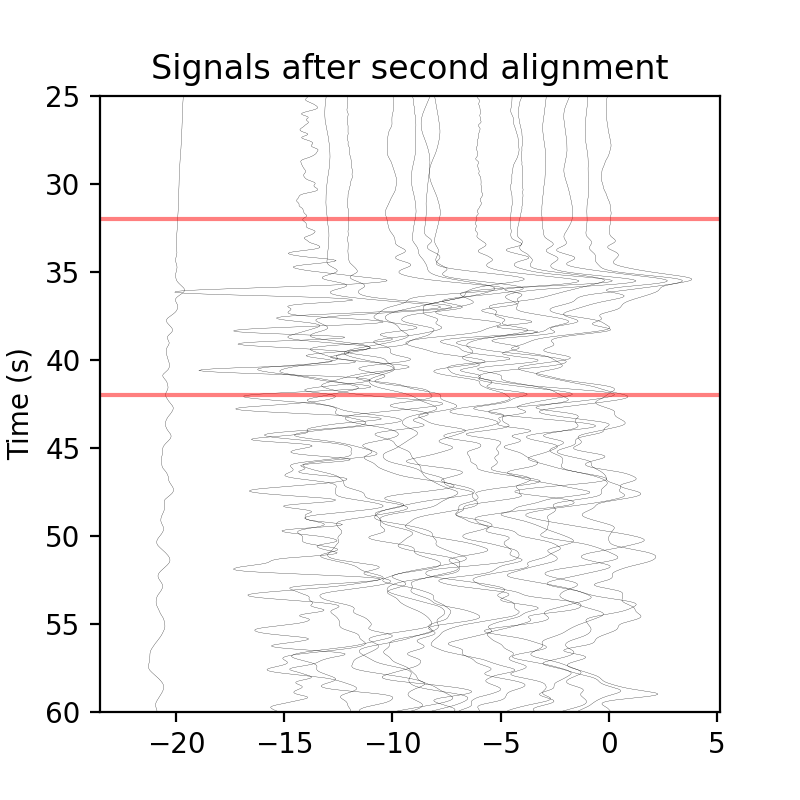

Text(0, 0.5, 'Time (s)')

In [12]:
# Verify if this is what we want
i=0
fig = plt.figure(figsize=(4,4))
plt.title('Signals after second alignment')
for i in range(Ns):
    sig = shifted_waveforms[i, :]
    time = np.arange(len(sig))/samp_rate
    plt.plot(sig/ sig.std()- i, time,  c='k', lw=0.1 )
    i+=1
plt.ylim(25.0, 60.0)
plt.axhline(y=tstart, color='r', alpha=0.5)
plt.axhline(y=tstart+twin, color='r', alpha=0.5)
plt.gca().invert_yaxis()
plt.ylabel('Time (s)')

#

Station nb above criterion:  12


<IPython.core.display.Javascript object>


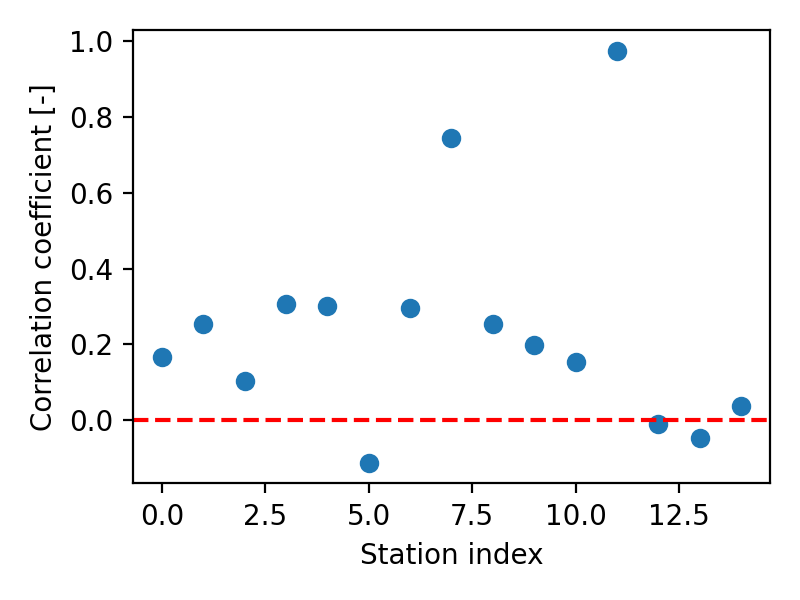

In [13]:
# Compute correlation coefficients
def get_most_coherents(time, shifted_waveforms, tbeg=None, tend=None, Rmin=None):
    # make template with shifted waveforms
    template = np.mean(shifted_waveforms, axis=0)
    template /= template.std()
    # compute coherence in chosen win
    cdt = (time >= tbeg) & (time <= tend)
    R = np.array([jazz.xcorr(wv, template[cdt]) for wv in shifted_waveforms[:, cdt]])[:, 1]
    R_inds = (R > Rmin)
    return R, R_inds, template
###



tbeg, tend, Rmin = 32.0, 40.0, 0.0
# tbeg, tend, Rmin = tstart, tstart+twin, 0.9

R, R_inds, template = get_most_coherents(time, shifted_waveforms, tbeg=tbeg, tend=tend, Rmin=Rmin)

print ('Station nb above criterion: ', shifted_waveforms[R_inds].shape[0])
plt.figure(figsize=(4,3))
plt.scatter(np.arange(len(R)), R)
plt.axhline(Rmin, c="r", ls="--")
plt.xlabel("Station index")
plt.ylabel("Correlation coefficient [-]")
plt.tight_layout()
plt.show()

# Third alignment with the most coherent signals
I use the same time window as I used for coherency test.

In [14]:
shifted_waveforms2, _ = jazz.align_hypocentre(shifted_waveforms[R_inds], hypo_dt=np.zeros(Ns), \
                                              start=int(tstart*samp_rate), win=int(twin*samp_rate))

<IPython.core.display.Javascript object>


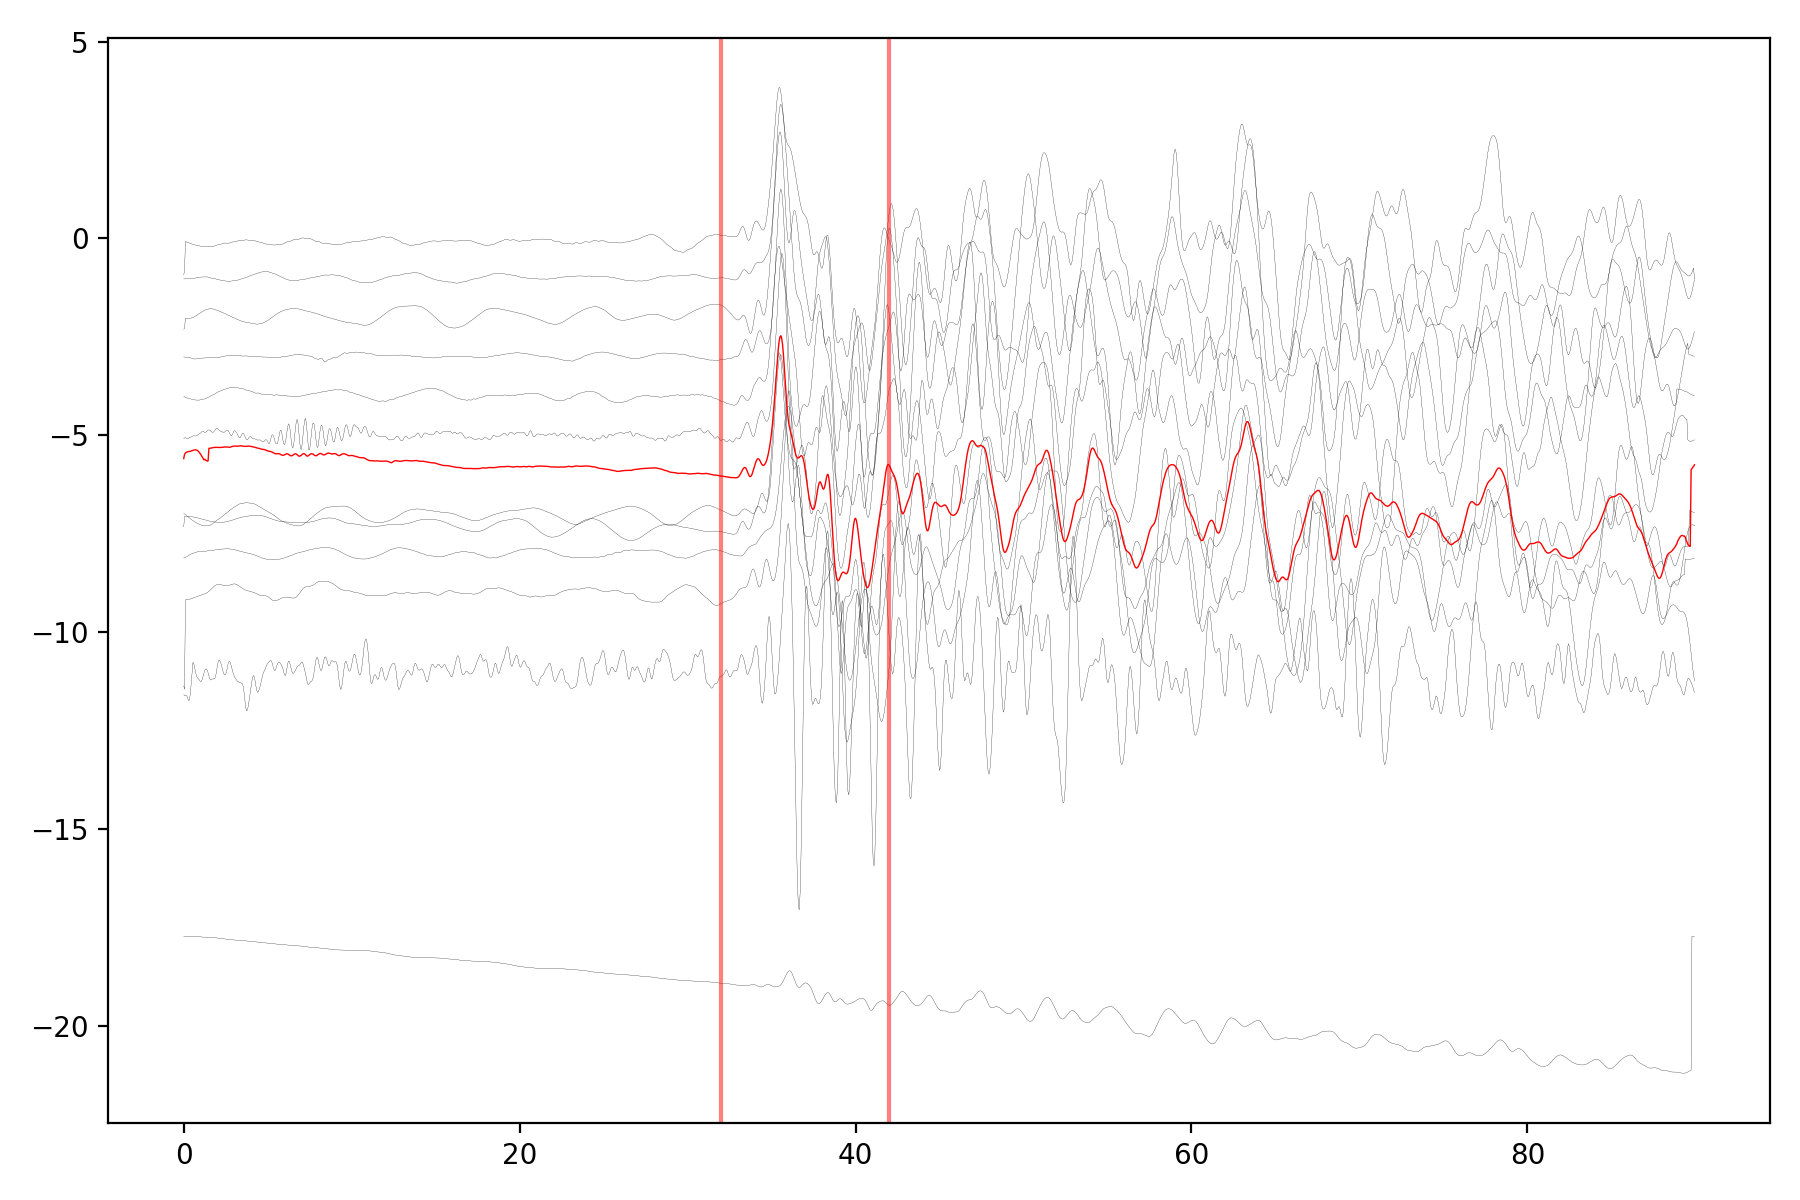

In [15]:
# plot after third alignment
# fig = plt.figure(figsize=(9, 12))
fig =  plt.figure(figsize=(9, 6))

for i, wv in enumerate(shifted_waveforms2):
    plt.plot(time, wv/ wv.std()- i, c="k", lw=0.1)
    
plt.plot(time, template- 1, c="r", lw=0.5)
plt.axvline(x=tstart, color='r', alpha=0.5)
plt.axvline(x=tstart+twin, color='r', alpha=0.5)
plt.tight_layout()
# fig.savefig('/Users/elifo/Desktop/alignment3.png', dpi=300)
plt.show()

# Coherence matrix computed for a given window
https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/

In [16]:
def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    
    import scipy
    import scipy.cluster.hierarchy as sch    

    
    # pairdist is based on Euclidian distance.
    # if each column is considered like a vector that 
    # gives the distance of each station to that distance,
    # returned vector is giving 2li kombinasyonlarinin distance'lari.
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    # fcluster: Forms flat clusters so that the original observations 
    # in each flat cluster have no greater a cophenetic distance than t,
    # t is cluster_distance_threshold here.
    cluster_distance_threshold = pairwise_distances.max()/2
    cluster_index = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    ista = np.argsort(cluster_index)

    unique, counts = np.unique(cluster_index, return_counts=True)
    cluster_counts = dict(zip(unique, counts))
    
    # make a dictionary to see which sta in which cluster
    cluster_dict = {}
    for clu in cluster_counts.keys():
        cluster_dict[str(clu)] = []
        for jj, sta in enumerate(cluster_index):
            if sta == clu:
                cluster_dict[str(clu)].append(jj)
    #        
    
    return corr_array[ista, :][:, ista], cluster_dict, cluster_index, cluster_counts
###

# Set a time window to compute coherency matrix
- I chose a win of xxx s.
- 10 sec as in Haiti paper (https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2011JB008702), that contains Pn.

In [17]:
tbeg, tend = 32.0, 40.0

signals = shifted_waveforms2

Ns = signals.shape[0]
cdt = (time >= tbeg) & (time <= tend)
# triangular matrix
corr_matrix = np.zeros((Ns, Ns))
for ii in range(Ns):
    sig1 = signals[ii, cdt]
    for jj in range(ii, Ns):        
        sig2 = signals[jj, cdt]
        __, Rmax = np.array(jazz.xcorr(sig1/sig1.std(), sig2/sig2.std()))
        corr_matrix[ii, jj] = Rmax
###    


# make it symmetrical
corr_matrix2 = corr_matrix.copy()

n = corr_matrix2.shape[0]
i_upper = np.triu_indices(n, 1)
i_lower = np.tril_indices(n, -1)
corr_matrix2[i_lower] = corr_matrix2.T[i_lower]
corr_matrix = corr_matrix2

<IPython.core.display.Javascript object>


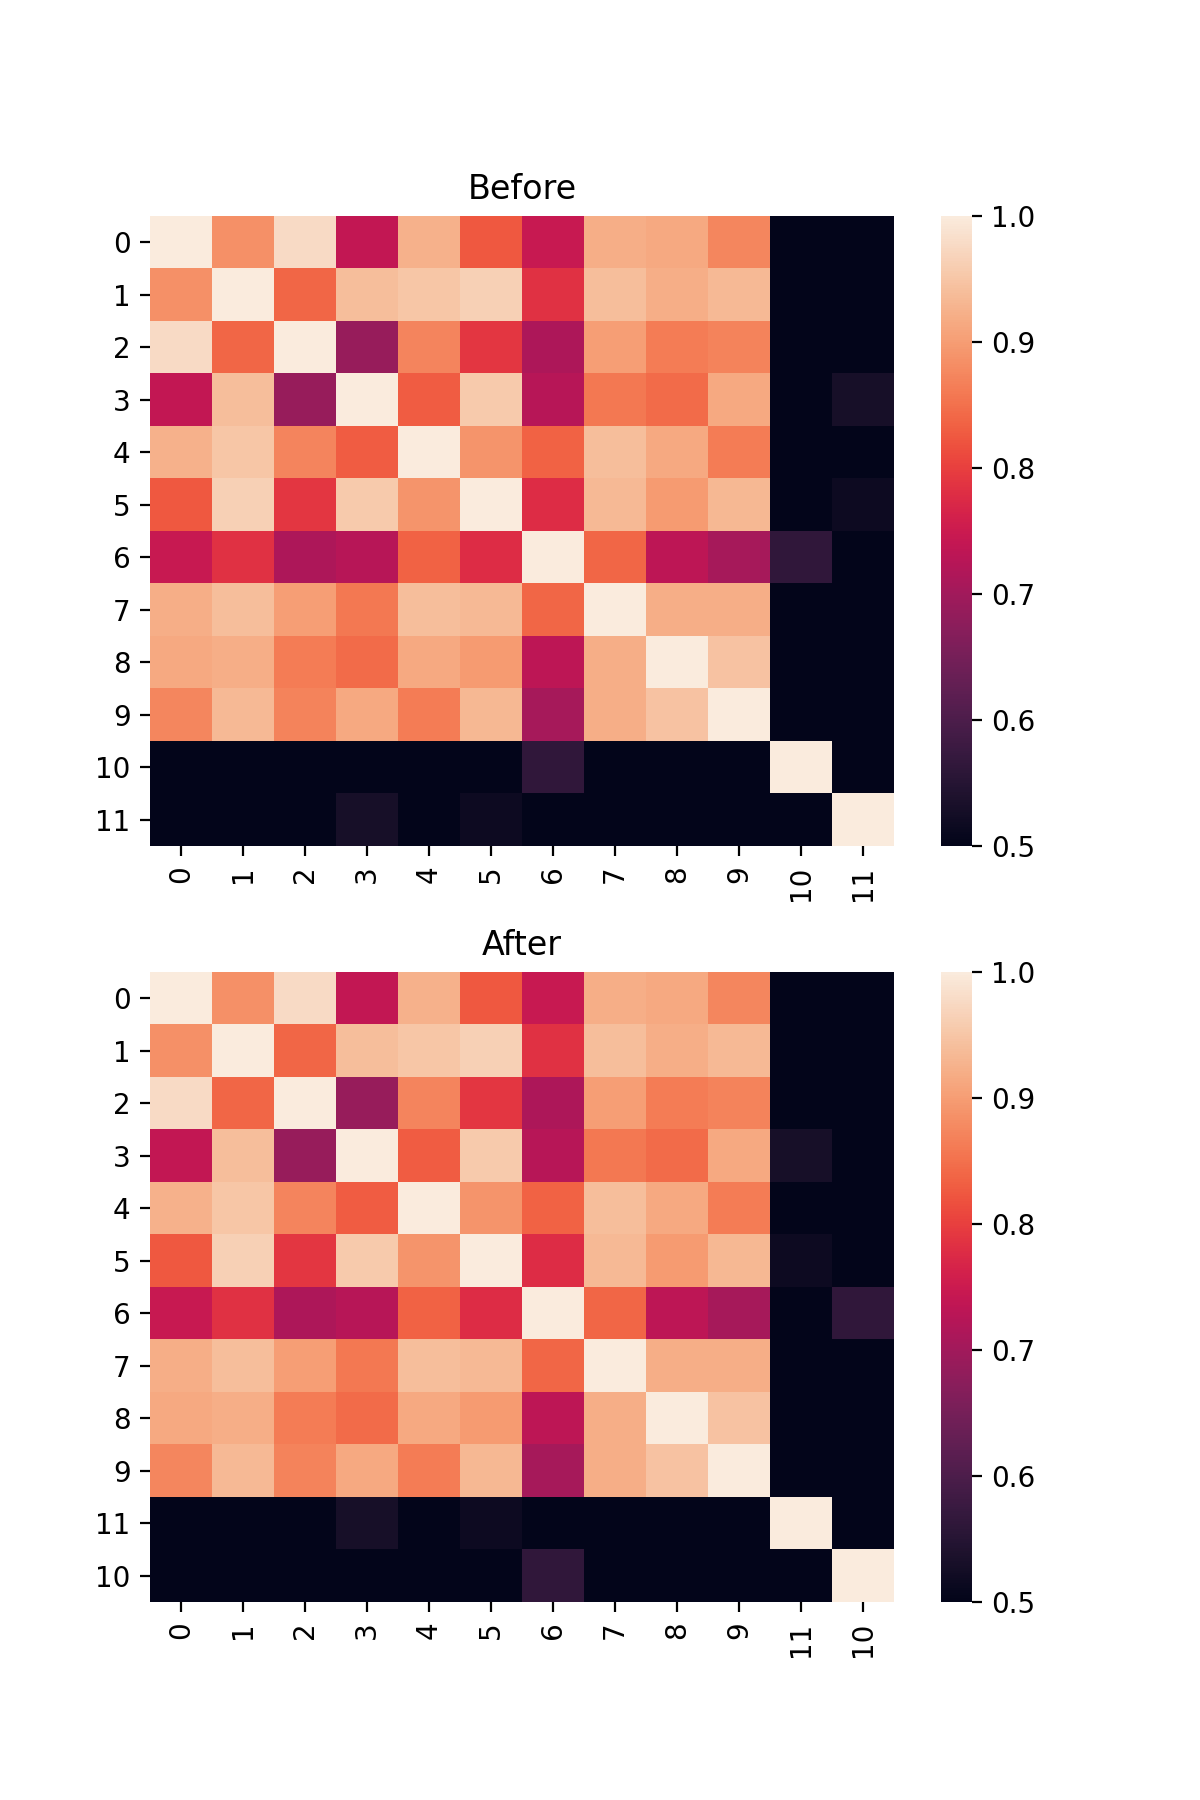

1 10
2 1
3 1


In [18]:
# MAke dataframe
import pandas as pd
import seaborn as sns
df = pd.DataFrame(corr_matrix)


# SORT 
array, cluster_dict, cluster_index, cluster_counts = cluster_corr(corr_matrix)

# sort the dataframe
df_sorted = df
columns = [df_sorted.columns.tolist()[i] for i in list((np.argsort(cluster_index)))]
df_sorted = df_sorted.reindex(columns, axis=1)
df_sorted = df_sorted.reindex(columns, axis=0)

# PLOT
fig = plt.figure(figsize=(6,9))
###
plt.subplot(211)
plt.title('Before')
sns.heatmap(df,  vmin=0.5, vmax=1.0)

plt.xticks(rotation=90); plt.yticks(rotation=0)
###
plt.subplot(212)
plt.title('After')
sns.heatmap(df_sorted,  vmin=0.5, vmax=1.0)
plt.xticks(rotation=90); plt.yticks(rotation=0)

for key in cluster_dict.keys():
    print (key, len(cluster_dict[key]) )

# fig.savefig('/Users/elifo/Desktop/clustered_sig.png', dpi=300)

# Plot selected cluster(s)
## I pick the cluster 1 with 10 stations
- I can choose one or multiple clusters

<IPython.core.display.Javascript object>


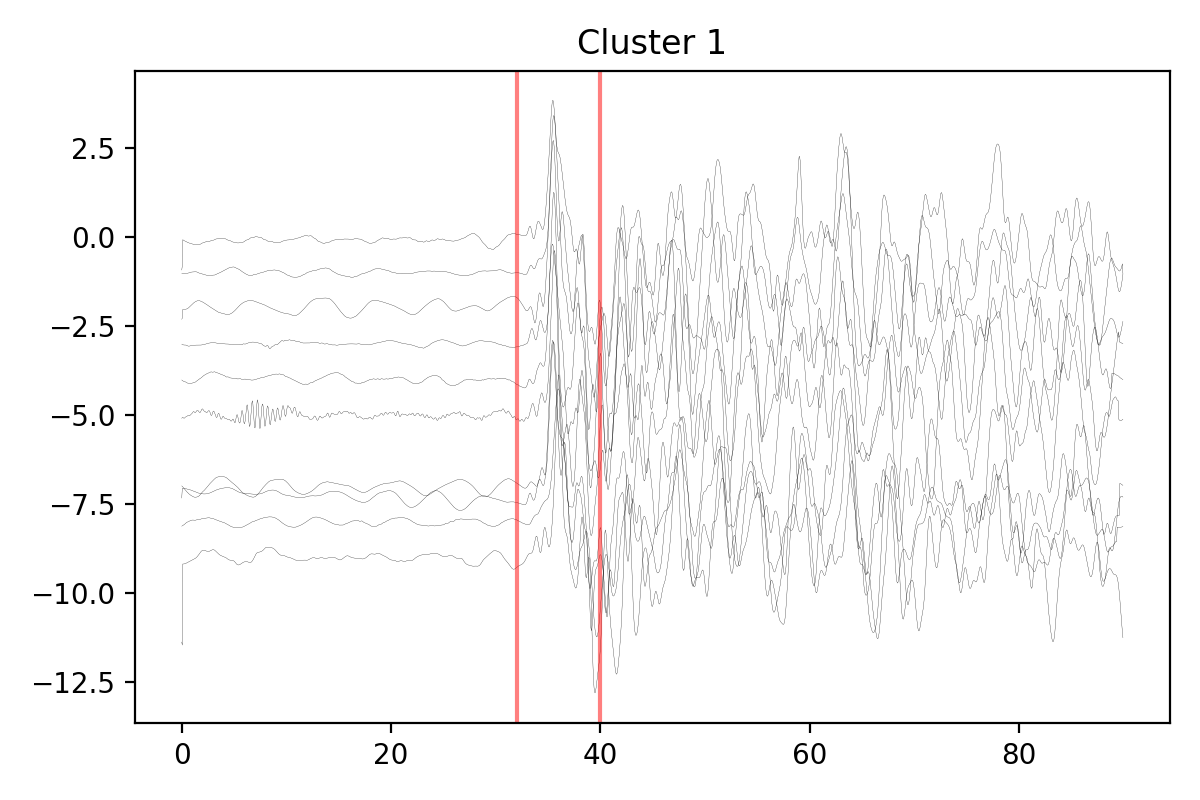

In [19]:
num = '1'
cluster = cluster_dict[num]
chosen_signals = signals[cluster]


# plot after clustering
# fig = plt.figure(figsize=(6,6 ))
fig = plt.figure(figsize=(6,4 ))

for i, wv in enumerate(chosen_signals):
    plt.plot(time, wv/ wv.std()- i, c="k", lw=0.1)
plt.title('Cluster '+ num)
# plt.xlim(20.0, 50.0)
plt.axvline(x=tbeg, color='r', alpha=0.5)
plt.axvline(x=tend, color='r', alpha=0.5)
plt.tight_layout()
# fig.savefig('/Users/elifo/Desktop/cluster_'+num+'.png', dpi=300)
plt.show()

Time win:  32.0 40.0
Station nb above criterion:  9


<IPython.core.display.Javascript object>


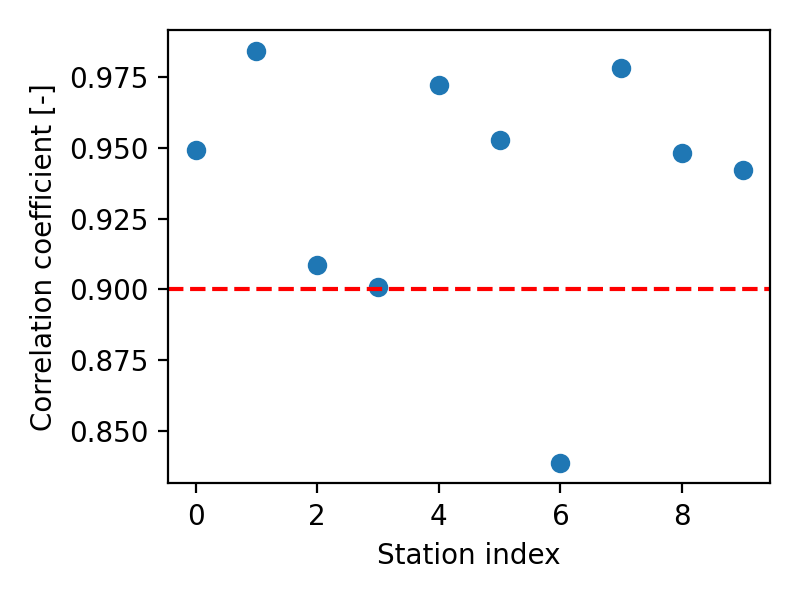

In [22]:

# tbeg, tend, Rmin = tstart, tstart+twin, 0.9
Rmin = 0.9
R, R_inds_cluster, template = get_most_coherents(time, chosen_signals, tbeg=tbeg, tend=tend, Rmin=Rmin)

print ('Time win: ', tbeg, tend)
chosen_signals2 = chosen_signals[R_inds_cluster]
lats_cluster = coords_selected[sort_inds][R_inds, 0][cluster][R_inds_cluster]
lons_cluster = coords_selected[sort_inds][R_inds, 1][cluster][R_inds_cluster]


print ('Station nb above criterion: ', chosen_signals2.shape[0])
plt.figure(figsize=(4,3))
plt.scatter(np.arange(len(R)), R)
plt.axhline(Rmin, c="r", ls="--")
plt.xlabel("Station index")
plt.ylabel("Correlation coefficient [-]")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


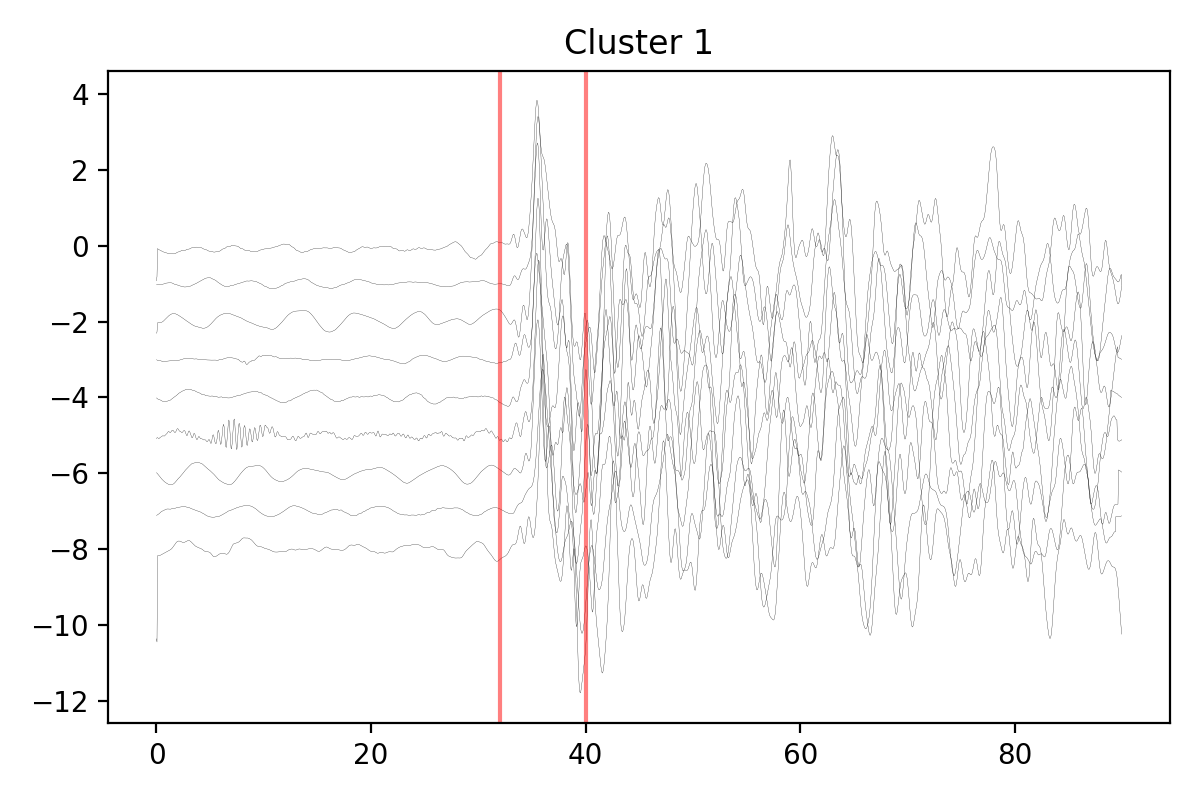

In [23]:

# plot after clustering
# fig = plt.figure(figsize=(6,6 ))
fig = plt.figure(figsize=(6,4 ))

for i, wv in enumerate(chosen_signals2):
    plt.plot(time, wv/ wv.std()- i, c="k", lw=0.1)
plt.title('Cluster '+ num)
# plt.xlim(20.0, 50.0)
plt.axvline(x=tbeg, color='r', alpha=0.5)
plt.axvline(x=tend, color='r', alpha=0.5)
plt.tight_layout()
# fig.savefig('/Users/elifo/Desktop/cluster_'+num+'.png', dpi=300)
plt.show()

# MUSIC

## Filter data before BP 
- Specify freq. band here

<IPython.core.display.Javascript object>


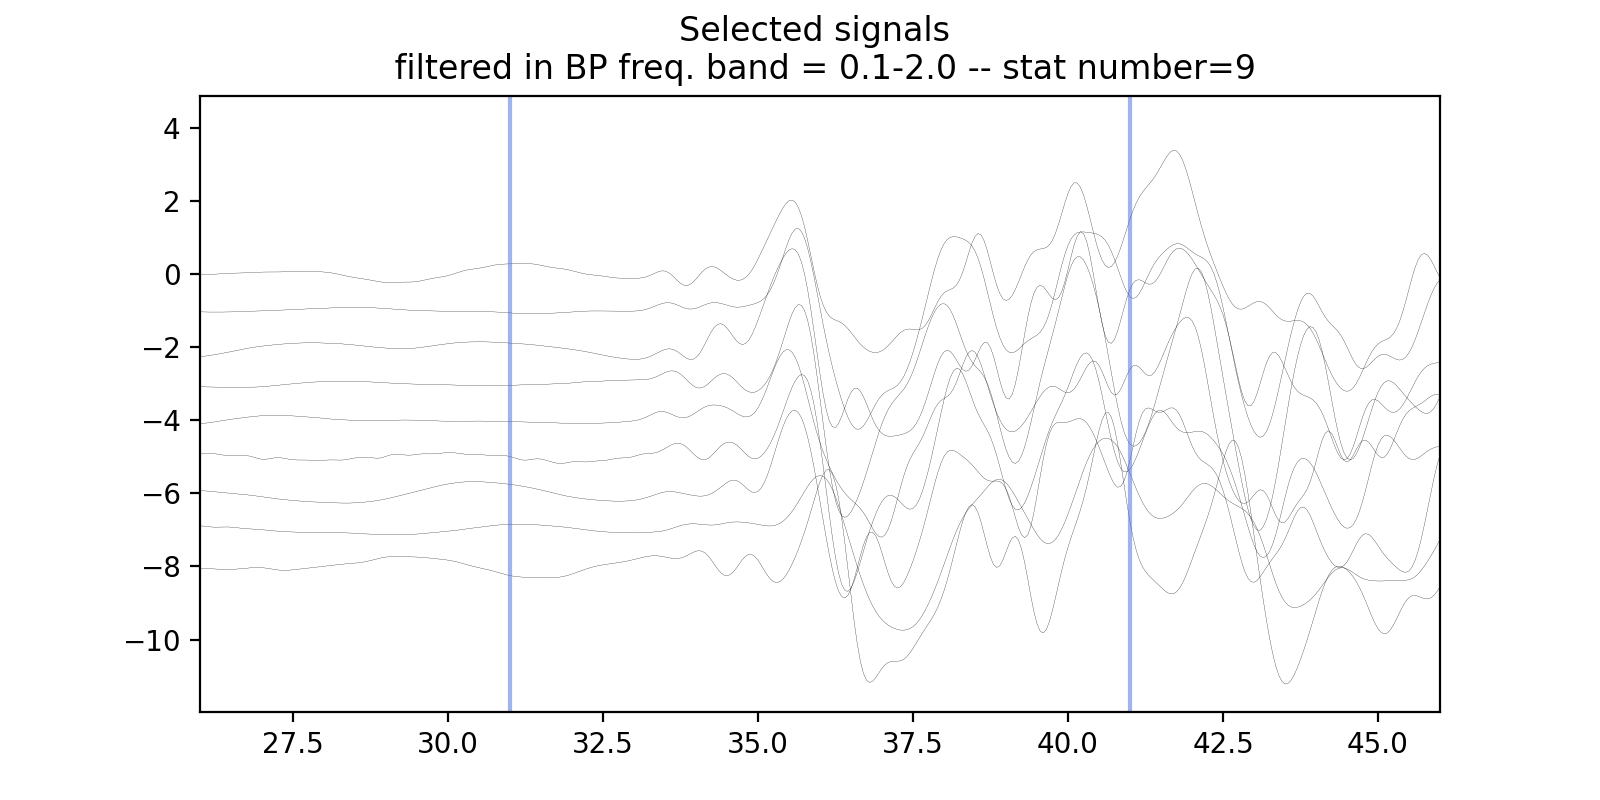

In [24]:
freq_band = np.array([0.1, 2.0])
tbeg, tend = 31.0, 41.0 


from filters import lowpass, highpass
dum = chosen_signals2
chosen_signals3 = np.zeros(chosen_signals2.shape)
fig = plt.figure(figsize=(8,4))
for i, vw in enumerate(dum):
    vw_filt = lowpass(vw, freq_band[1], df=samp_rate, corners=4, zerophase=False)
    vw_filt = highpass(vw_filt, freq_band[0], df=samp_rate, corners=4, zerophase=False)
    chosen_signals3[i,:] = vw_filt
    plt.plot(time, vw_filt/vw_filt.std()-i,  c="k", lw=0.1 )
plt.axvline(x=tbeg, color='royalblue', alpha=0.5)
plt.axvline(x=tend, color='royalblue', alpha=0.5)
plt.xlim(tbeg-5.0, tend+5.0)
plt.title('Selected signals \n filtered in BP freq. band = '+ str(freq_band[0])+'-'+ str(freq_band[1])+' -- stat number='+ str(len(chosen_signals3)))
plt.show()



In [25]:
# waveforms = chosen_signals2
waveforms = chosen_signals3

print ('waveforms', waveforms.shape)

stations_df = pd.DataFrame(data={
    "lat": lats_cluster,
    "lon": lons_cluster,
})

params = {
    "origin": {
        "lat": lat_ev,
        "lon": lon_ev,
        "depth": source_depth,
    },
    # Source location grid (Nx, Ny)
    "grid_size": (200, 200),
    
    # Source location grid extent (+/- lon, +/- lat)
    "grid_extent": (0.7, 0.7),

    # Sampling frequency of the waveforms
    "fsamp": jazz.fsamp,
    
    # Velocity model
    "ptimes_file": './src/Ptimesdepth.mat',
}



waveforms (9, 1800)


In [26]:
print ('Playing music ...')
jazz.set_params(params)
jazz.set_params(params)
jazz.construct_spatial_grid()
jazz.stations = stations_df
jazz.read_time_grid()
jazz.construct_times_backprojection()
print("*")

Playing music ...
  Constructing source location grid
  Reading velocity model
  Constructing travel time look-up table
*


# Back-projection

In [27]:

stride = 1.0
win = 6.0


###
f_cen = 0.5* (freq_band[0]+freq_band[1]) 
print ('Time win:', tbeg, tend)
print ('Suggested window range = ', 5.0/f_cen, 10.0/f_cen  )
print ('Sliding window set = ', win  )

time = np.arange(Nt)/samp_rate
cdt = (time >= tbeg) & (time <= tend)

P = jazz.do_backprojection(
    data=waveforms[:, cdt], freq_band=freq_band, 
    sources=2, win=win, stride=stride, 
    mode="MUSIC", jit=True
)

print("*")

Time win: 31.0 41.0
Suggested window range =  4.7619047619 9.52380952381
Sliding window set =  6.0
Start back-projection
Processing 1 / 4 [ETA: 0 s]
Processing 2 / 4 [ETA: 5 s]
Processing 3 / 4 [ETA: 2 s]
Processing 4 / 4 [ETA: 1 s]
*


# BP results

In [28]:
source = np.log10(1/P.copy()) 
N_source = source.shape[0]

Nx, Ny = jazz.grid_size
x = jazz.grid["x"]
y = jazz.grid["y"]

locs = np.zeros((N_source, 2))
for n in range(N_source):
    n_max = np.argmax(source[n])
    i, j = np.unravel_index(n_max, shape=source[n].shape)
    locs[n] = [x[i], y[j]]
###

## Project solution points onto the fault strike
- I call get_fault_strike to create a fault strike for a given strike angle, line length, and reference point.


In [29]:
# Fault strike (HRCS027: Petrinja fault)
lon_strike, lat_strike = get_fault_strike (strike=320.0, beg_loc=(44.3797754229,  17.164139262), line_length=-300.0 )

print (lon_ev, lat_ev)

ref_lon, ref_lat = lon_strike[-1], lat_strike[-1]
print (ref_lon, ref_lat)
projection = []; dist_2_ref = []
for _lon, _lat in zip(locs[:, 0], locs[:, 1]):
    point = get_projection_on_strike(lon_strike, lat_strike, _lon, _lat)
    projection.append(point)    
    d = get_distance_btw_points(ref_lon, ref_lat, point[0], point[1])
    dist_2_ref.append(d)
###

time_sol = np.arange(N_source)* stride

xx, yy = np.meshgrid(x,y)
point = get_projection_on_strike(lon_strike, lat_strike, lon_ev, lat_ev)
d_hypo = get_distance_btw_points(ref_lon, ref_lat, point[0], point[1])
print ('Distance btw epicenter and ref. point on strike:', d_hypo)

#

16.298 45.412
17.164139262 44.3797754229
Distance btw epicenter and ref. point on strike: 150.0


## Plot

<IPython.core.display.Javascript object>


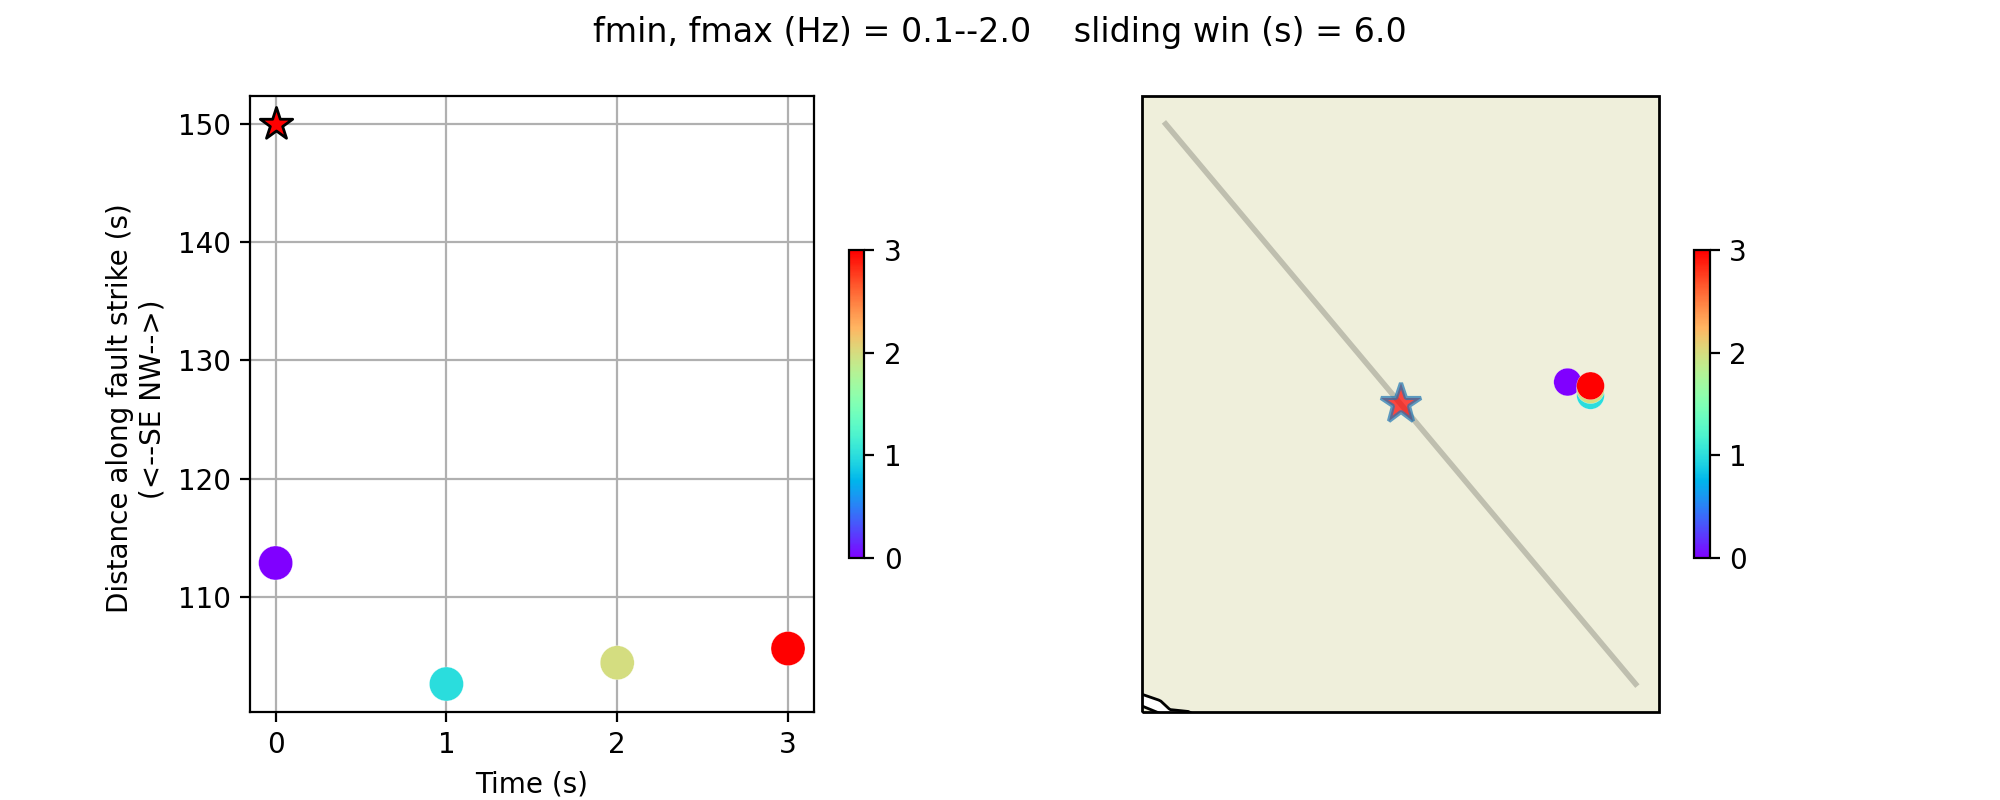

In [30]:
fig = plt.figure(figsize=(10,4))
cmap = 'rainbow'
plt.suptitle('fmin, fmax (Hz) = '+ str(freq_band[0])+'--'+str(freq_band[1])+\
            '    sliding win (s) = '+ str(win))

###
plt.subplot(121)
plt.scatter(0.0, d_hypo, marker='*', s=150, c='r',ec='k', zorder=9998)
im = plt.scatter(time_sol, dist_2_ref, c=time_sol, s=150, cmap=cmap, 
    lw=0.1, ec="white", zorder=9998)
plt.colorbar(im, shrink=0.5)
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Distance along fault strike (s) \n (<--SE NW-->)')

###
# plt.subplot(122)
ax = fig.add_subplot(122, projection=ccrs.PlateCarree())
grid_minlon, grid_maxlon, grid_minlat, grid_maxlat = 16, 16.5,  45.3, 45.7
# add NaturalEarthFeature
land_10m = cfeature.NaturalEarthFeature("physical", "land", "10m", \
                        edgecolor="face", facecolor=cfeature.COLORS["land"])
ax.add_feature(land_10m)
ax.coastlines(resolution="10m")
# solution locs
im = plt.scatter(locs[:, 0], locs[:, 1], c=time_sol, s=100, cmap=cmap, 
    lw=0.1, ec="white", zorder=9998)
# epicenter
plt.plot(jazz.origin["lon"], jazz.origin["lat"], "*", markersize=15, 
    markerfacecolor="r", markeredgewidth=1.5, zorder=9999, alpha=0.7)


# fault strike
plt.plot(lon_strike, lat_strike, c="k", lw=2, alpha=0.2)
# fault grid
# plt.scatter(xx,yy, zorder=9998, alpha=0.002)
# plt.scatter(ref_lon, ref_lat, zorder=9998)
plt.colorbar(im, shrink=0.5)
plt.show()

# Plot locations of the finally used stations

<IPython.core.display.Javascript object>


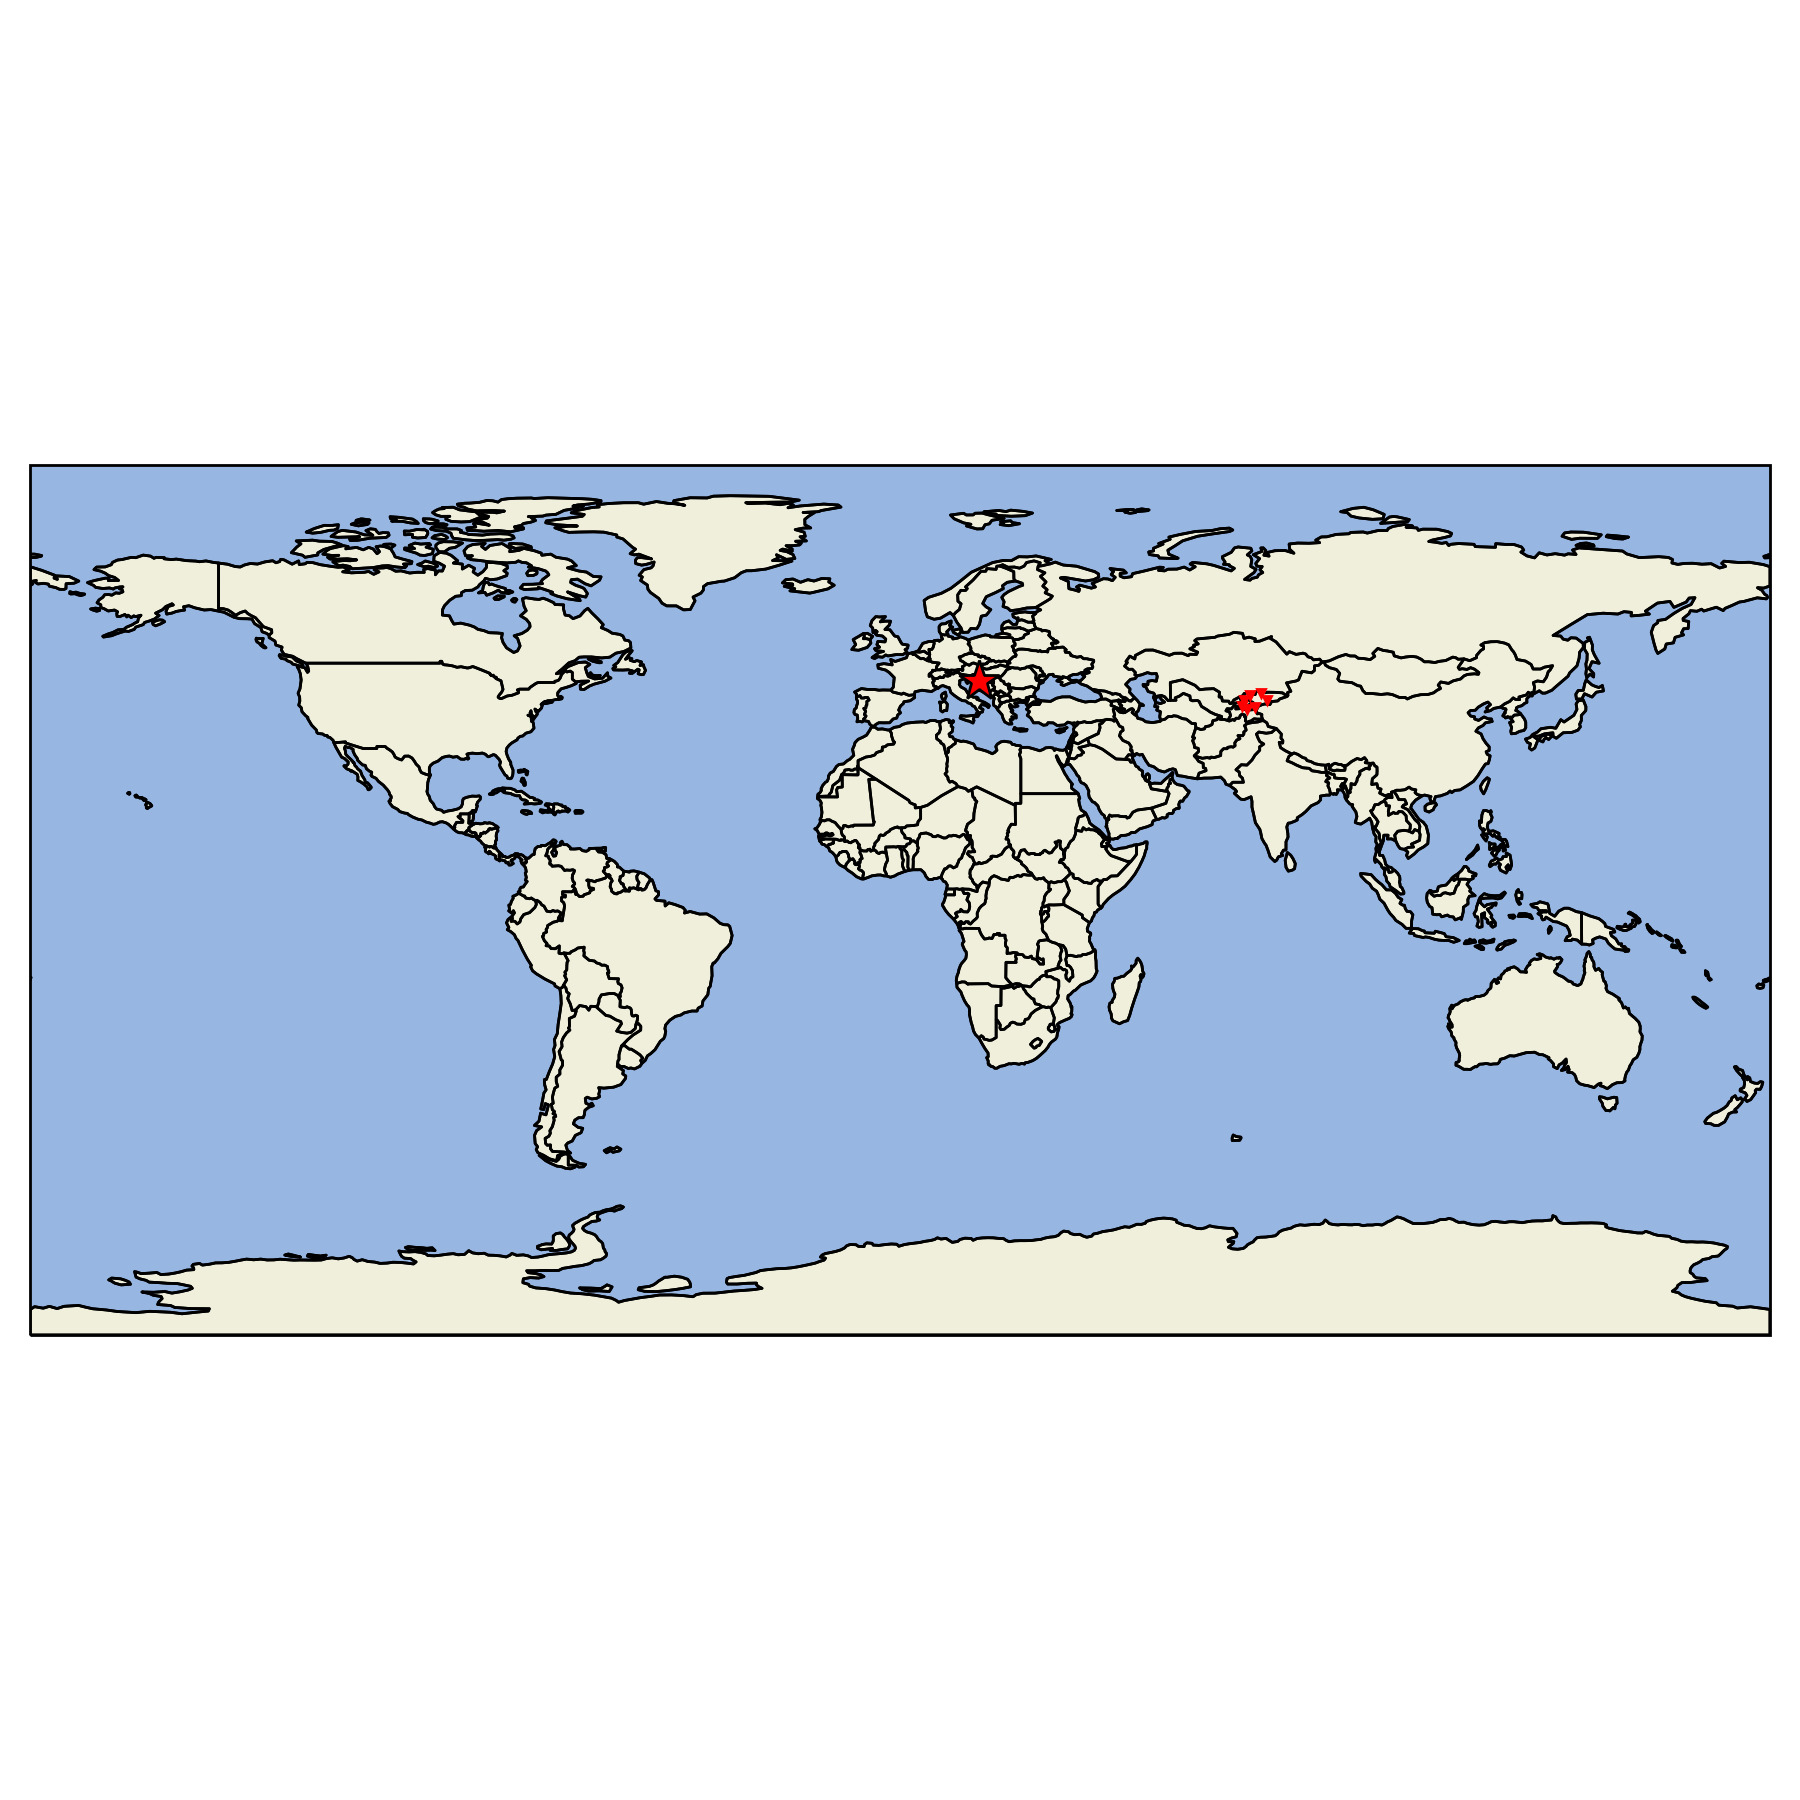

In [65]:
# PLOT SELECTED STATIONS
plt.close('all')
fig = plt.figure(figsize=(9, 9))

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

resolution = "110m"

# ax.set_xlim((-180, 45))
# ax.set_ylim((15, 90))

ax.imshow(np.tile(np.array([[cfeature.COLORS['water'] * 255]], dtype=np.uint8), [1,1, 1]), origin='upper', transform=ccrs.PlateCarree(), extent=[-180, 180, -180, 180])
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor=cfeature.COLORS['land']))
ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', resolution, edgecolor='black', facecolor='none'))

# ax.plot(source_coords[1], source_coords[0], "r*", zorder=999, ms=15, mew=1, mec="k")
# ax.plot(station_coords[:, 1], station_coords[:, 0], "rv", ms=3, zorder=999)
ax.plot(jazz.origin["lon"], jazz.origin["lat"], "r*", zorder=999, ms=15, mew=1, mec="k")
ax.plot(lons_cluster, lats_cluster, "rv", ms=3, zorder=999)



plt.tight_layout()
plt.show()